Libraries

In [1]:
import torch
import cv2
import torchvision
from torch import nn
from torch import optim
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision import models
from torch.utils.data import Dataset, Subset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.RandomHorizontalFlip()])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:05<00:00, 28974688.06it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
subset = torch.utils.data.Subset(trainset, indices=np.arange(40000))
trainloader = torch.utils.data.DataLoader(subset, batch_size=128, num_workers=2)

In [5]:
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(test_set, batch_size=128,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [6]:
def adjust_learning_rate(optimizer, epoch, lr):
    lr = lr * (0.5 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [7]:
def train(device,model, loader,epoch): 
    accur = []
    losses = []
    model.train() 
    for i in range(epoch):
        
        adjust_learning_rate(optimizer, i, lr)
        running_loss = []
        correct=0
        for batch, label in loader:
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad() 
            pred = model(batch) 
            loss = criterion(pred, label) 
            running_loss.append(loss.item())
            loss.backward() 
            optimizer.step() 
            correct += (torch.argmax(pred,dim=1)==label).sum().item()
        acc = correct/len(loader.dataset)
        accur.append(acc)
        
        losses.append(np.mean(running_loss))
        print("==================================================")
        print(f"Epoch {i+1}\t\t Accuracy : {acc*100:.4f}%")
        print("\t\tloss: {}".format(np.mean(running_loss))) 
    return accur,losses

In [8]:
def evaluate(model, loader): 
    model.eval() 
    correct = 0
    with torch.no_grad(): 
        for batch, label in loader:
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            correct += (torch.argmax(pred,dim=1)==label).sum().item()
    acc = correct/len(loader.dataset)
    print("The overall test accuracy on the model is {}%".format(acc*100))
    return acc

In [9]:
accur = []
loss = []
lr = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.vgg16_bn(pretrained=True)
input_lastLayer = model.classifier[6].in_features
model.classifier[6] = torch.nn.Linear(input_lastLayer, 10)
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr,weight_decay=5e-4)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:09<00:00, 60.7MB/s]


In [10]:
accur, loss = train(device,model, trainloader, 30)

Epoch 1		 Accuracy : 25.7900%
		loss: 2.085255899749244
Epoch 2		 Accuracy : 48.3550%
		loss: 1.4974871969070678
Epoch 3		 Accuracy : 59.2250%
		loss: 1.1680165167433767
Epoch 4		 Accuracy : 65.8650%
		loss: 0.9806820963518307
Epoch 5		 Accuracy : 70.0800%
		loss: 0.86173343372802
Epoch 6		 Accuracy : 73.1900%
		loss: 0.7748326755369814
Epoch 7		 Accuracy : 75.5150%
		loss: 0.7101339777818503
Epoch 8		 Accuracy : 77.5100%
		loss: 0.652647577630826
Epoch 9		 Accuracy : 79.2025%
		loss: 0.6032487120681678
Epoch 10		 Accuracy : 80.5350%
		loss: 0.5641875924965063
Epoch 11		 Accuracy : 81.5100%
		loss: 0.5350990469653767
Epoch 12		 Accuracy : 82.8600%
		loss: 0.49637988371590075
Epoch 13		 Accuracy : 83.7575%
		loss: 0.4706538015375503
Epoch 14		 Accuracy : 84.6450%
		loss: 0.4446495282954682
Epoch 15		 Accuracy : 85.4500%
		loss: 0.41987733495311613
Epoch 16		 Accuracy : 86.3350%
		loss: 0.39664309493269023
Epoch 17		 Accuracy : 86.9575%
		loss: 0.37525561504280225
Epoch 18		 Accuracy : 8

In [11]:
torch.save(model, "vgg_cifar.h5")

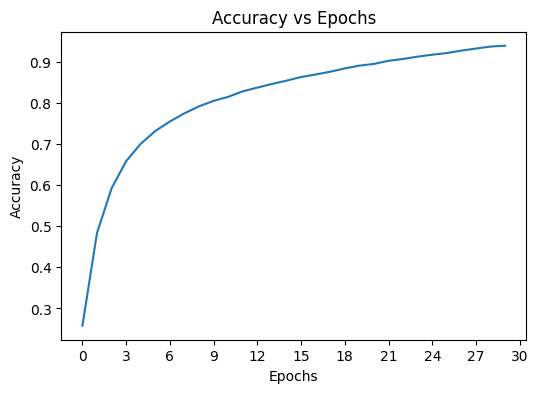

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(accur)
ax.set_title("Accuracy vs Epochs")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
ax.set_xticks(range(0,32,3))

plt.show()

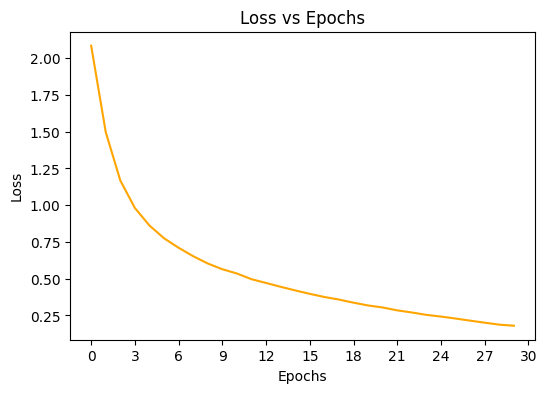

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(loss,color='orange')

ax.set_title("Loss vs Epochs")
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
ax.set_xticks(range(0,32,3))

plt.show()

In [14]:
og_acc = evaluate(model, testloader)

The overall test accuracy on the model is 83.17%


In [15]:
class PerturbPGDIterBuff():
    def __init__(self, model, epsilon=0.007, alpha=0.001):
        self.epsilon = epsilon
        self.model = model
        self.steps = 2
        self.alpha = alpha
        self.device = device
    
    def attack(self, X, y, steps=None):
        if steps != None:
            self.steps = steps
        
        X_updt = torch.autograd.Variable(X.data, requires_grad=True)
        all_step_X_updts = [None] * (self.steps-2)
        
        
        for i in range(0,self.steps):
            pred = self.model(X_updt)
            self.model.zero_grad()
            loss = F.cross_entropy(pred, y)
            loss.backward()
            alphas = alpha * torch.sign(X_updt.grad)
            X_updt = torch.autograd.Variable(X_updt + alphas, requires_grad=True)
            X_updt = torch.autograd.Variable(X_updt + torch.clamp(X_updt - X, min=-self.epsilon, max=self.epsilon), requires_grad=True)
            diff = X_updt - X
            if i >= 0:
                all_step_X_updts[i-2] = diff.detach().cpu().numpy()
        return all_step_X_updts



In [16]:
def get_attack_meta(model, loader, attack, attack_name, steps=None):
    
    final_set_of_samples = []
    
    model.eval() 
    correct = 0
    with torch.no_grad(): 
        for batch, label in loader:
            batch = batch.to(device)
            label = label.to(device)
            with torch.enable_grad():
                if attack_name == "PGD":
                    batch_pert = attack.attack(batch, label, steps)
            final_set_of_samples.append(batch_pert)
            
    return final_set_of_samples

Taking up new datasets for attacking


In [17]:
transform = transforms.Compose(
    [transforms.ToTensor()])
batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

subset = torch.utils.data.Subset(trainset, indices=np.arange(40000))

trainloader = torch.utils.data.DataLoader(subset, batch_size=batch_size, num_workers=2)

Files already downloaded and verified


In [18]:
epsilon = 25./255.
alpha = 0.001
succ_rate = []
meta = {}

final_perturbation_maps = get_attack_meta(model, trainloader, PerturbPGDIterBuff(model, epsilon, alpha), "PGD", steps=8)

In [19]:
final_perturbation_maps = np.asarray(final_perturbation_maps)

In [20]:
for i in range(final_perturbation_maps.shape[1]):
    pgd_step_maps = np.concatenate(final_perturbation_maps[:,1,:])
    joblib.dump(pgd_step_maps, f"perturbation_mapsPGD_40k_steps{i+2}.dump")

In [21]:
del final_perturbation_maps

In [22]:
pert_map_loaded = joblib.load("perturbation_mapsPGD_40k_steps5.dump")

In [23]:
pert_map_loaded[0][0]

array([[-0.01800004, -0.02600005, -0.03000006, ...,  0.02999961,
         0.01399982,  0.01799977],
       [ 0.02600005,  0.03      ,  0.002     , ...,  0.01399982,
        -0.01799977,  0.02999958],
       [-0.00600001,  0.01800004,  0.02200004, ..., -0.02999961,
         0.02999958, -0.01799977],
       ...,
       [-0.01799977, -0.02999961,  0.01799977, ..., -0.02999961,
         0.02200004,  0.00600001],
       [ 0.01399982,  0.02999961,  0.01799977, ..., -0.02599967,
         0.02199972, -0.02599967],
       [ 0.00599992, -0.02599967,  0.00199997, ...,  0.01399982,
        -0.02599967, -0.02599967]], dtype=float32)

In [24]:
pert_map_loaded[0][1]

array([[-0.02200004, -0.01800004, -0.01800004, ..., -0.00599992,
         0.01399985,  0.01799974],
       [ 0.02600005,  0.014     ,  0.002     , ..., -0.01799977,
        -0.01799977,  0.01399982],
       [-0.00600001,  0.01800003,  0.02200004, ..., -0.02999961,
         0.01799977, -0.02999961],
       ...,
       [-0.02599967, -0.01399982,  0.02199972, ...,  0.02999961,
         0.02600005,  0.03000006],
       [ 0.02599967,  0.0259997 ,  0.02599967, ...,  0.02999961,
         0.02600013,  0.02600005],
       [ 0.01799977, -0.00199997,  0.02199972, ...,  0.02599967,
         0.02599967,  0.01399982]], dtype=float32)

In [25]:
pert_map_loaded[0][2]

array([[-0.01800004, -0.01800004, -0.01800004, ..., -0.00599992,
        -0.01799977,  0.01399982],
       [-0.002     , -0.018     , -0.03      , ..., -0.01800004,
        -0.01800004,  0.01400003],
       [-0.01800004, -0.03      ,  0.02199996, ..., -0.03000006,
        -0.002     , -0.01800004],
       ...,
       [-0.02599967, -0.03000006,  0.03000005, ..., -0.02999961,
        -0.03      , -0.01400003],
       [-0.02999961, -0.02200004, -0.00600001, ..., -0.02999961,
        -0.03000006, -0.01400003],
       [-0.02999961, -0.01799977,  0.00599992, ..., -0.02999961,
        -0.02999961, -0.02599967]], dtype=float32)

In [26]:
r_channels = np.concatenate(pert_map_loaded[:,0,:])
g_channels = np.concatenate(pert_map_loaded[:,1,:])
b_channels = np.concatenate(pert_map_loaded[:,2,:])

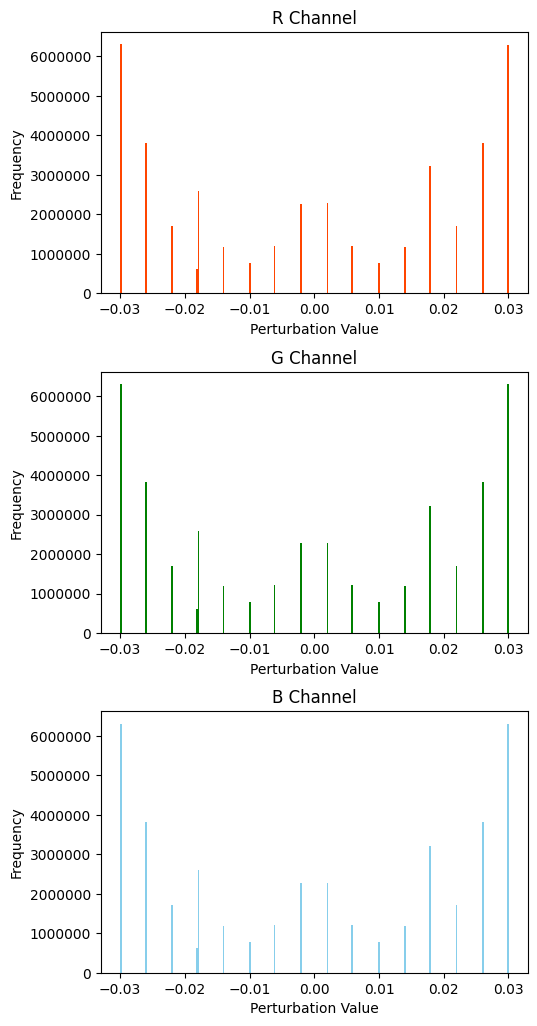

In [27]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5,10))
title = "RGB"
fig.tight_layout()
colors = ['orangered','green','skyblue']
for i,c in enumerate([r_channels, g_channels, b_channels]):
  temp = r_channels.flatten()
  q25, q75 = np.percentile(temp, [25, 75])
  bin_width = 2 * (q75 - q25) * len(temp) ** (-1/3)
  bins = round((temp.max() - temp.min()) / bin_width)

  ax[i].hist(temp,density=False,bins=bins, color=colors[i])
  ax[i].set_title(f"{title[i]} Channel")
  ax[i].set_xlabel("Perturbation Value")
  ax[i].set_ylabel("Frequency")
  ax[i].ticklabel_format(useOffset=False, style='plain')
fig.subplots_adjust(hspace=0.3)
plt.show()

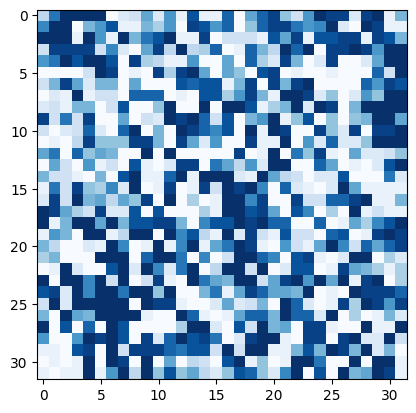

In [28]:
temp = pert_map_loaded[5][0] + 1
plt.imshow(temp / temp.max(), cmap='Blues')

In [29]:
value_weights = np.array(np.unique(r_channels.flatten(), return_counts = True))
value_weights[1] = value_weights[1] / value_weights[1].sum()

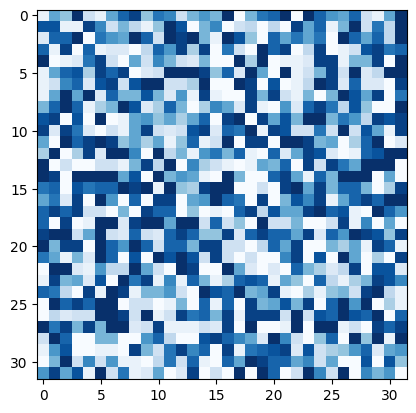

In [30]:
random_mat = np.random.choice(value_weights[0], p=value_weights[1], size=(32,32)) + 1
plt.imshow(random_mat / random_mat.max(), cmap='Blues')

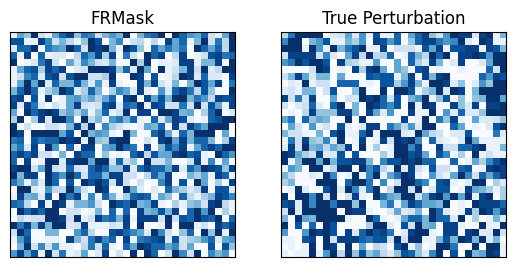

In [31]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(random_mat / random_mat.max(), cmap='Blues')
axs[0].set_title("FRMask")
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(temp / temp.max(), cmap='Blues')
axs[1].set_title("True Perturbation")
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.show()

In [32]:
random_mat

array([[0.97400033, 1.00199997, 0.99400008, ..., 0.97400033, 1.002     ,
        1.03000006],
       [1.02199972, 1.02199972, 0.97399995, ..., 1.01399982, 0.98600018,
        1.02999973],
       [0.97800028, 1.01799977, 1.01799977, ..., 1.01799977, 0.98600018,
        1.02999961],
       ...,
       [0.97400033, 1.006     , 1.02199972, ..., 0.97800028, 1.002     ,
        1.00599992],
       [0.96999994, 0.99800003, 1.02999961, ..., 0.9700003 , 1.02200004,
        0.99400008],
       [1.00599992, 1.02599964, 1.00199997, ..., 0.99800003, 1.00599992,
        0.97000039]])

In [33]:
def apply_pmap(img, val_weights,single):
    if single:

      for i in range(img.shape[0]):
          random_mat = np.random.choice(val_weights[i][0], p=val_weights[i][1], size=img.shape[1:])
          img[i] += random_mat
      return img

    else:
      out = []
      for img in batch.numpy():
          for i in range(img.shape[0]):
              random_mat = np.random.choice(val_weights[i][0], p=val_weights[i][1], size=img.shape[1:])
              img[i] += random_mat
          out.append(img)
              
      return torch.tensor(np.array(out)) 



In [34]:
def return_t(t):
  t_base = cv2.rotate(t.T, cv2.ROTATE_90_CLOCKWISE)
  t_adv = pert_map_loaded[ar[i]] + t
  t_adv = cv2.rotate(t_adv.T, cv2.ROTATE_90_CLOCKWISE)
  t_adv[t_adv < 0] = 0.2
  r = np.array(np.unique(r_channels.flatten(), return_counts = True))
  r[1] = r[1] / r[1].sum()
  g = np.array(np.unique(g_channels.flatten(), return_counts = True))
  g[1] = g[1] / g[1].sum()
  b = np.array(np.unique(b_channels.flatten(), return_counts = True))
  b[1] = b[1] / b[1].sum()
  val_weights = [r,g,b]
  t_pert = apply_pmap(t, val_weights,True)
  t_pert[t_pert < 0] = 0.2
  t_pert = cv2.rotate(t_pert.T, cv2.ROTATE_90_CLOCKWISE)
  return t_base,t_adv,t_pert

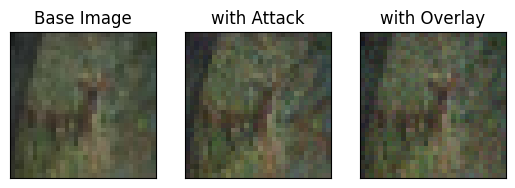

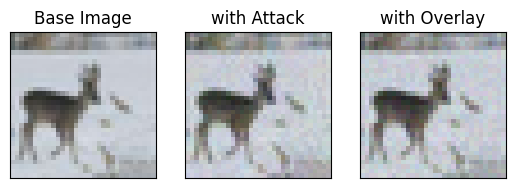

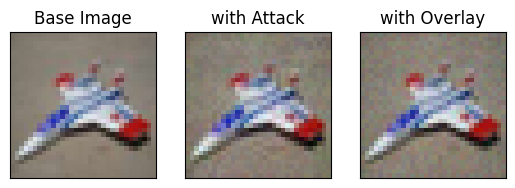

In [35]:
ar = [10,20,30]

for i in range(3):

    for x,y in trainloader:
        t = x[ar[i]].detach().cpu().numpy()
        break
    t1,t2,t3 = return_t(t)
    fig, axs = plt.subplots(1,3)
    axs[0].imshow(t1)
    axs[0].set_title("Base Image")
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    axs[1].imshow(t2)
    axs[1].set_title("with Attack")
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    axs[2].imshow(t3)
    axs[2].set_title("with Overlay")
    axs[2].set_xticks([])
    axs[2].set_yticks([])

    plt.show()

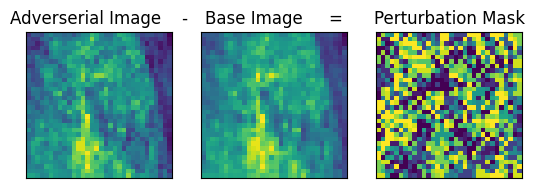

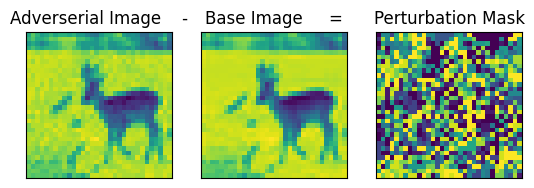

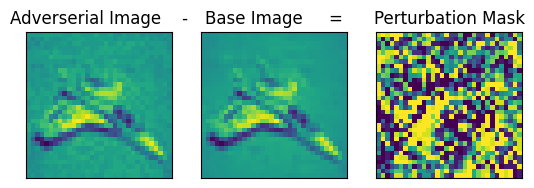

In [36]:
for i in range(3):

  for x,y in trainloader:
        t = x[ar[i]].detach().cpu().numpy()
        break
  t1,t2,t3 = return_t(t)
  fig, axs = plt.subplots(1,3)

  temp = cv2.rotate(t2.T[0], cv2.ROTATE_90_CLOCKWISE)
  axs[0].imshow(temp)
  axs[0].set_title("Adverserial Image    -")
  axs[0].set_xticks([])
  axs[0].set_yticks([])

  temp = cv2.rotate(t1.T[0], cv2.ROTATE_90_CLOCKWISE)
  axs[1].imshow(temp)
  axs[1].set_title("Base Image     =", horizontalalignment='center')
  axs[1].set_xticks([])
  axs[1].set_yticks([])

  temp = cv2.rotate(t2.T[0] - t1.T[0], cv2.ROTATE_90_CLOCKWISE)
  axs[2].imshow(temp)
  axs[2].set_title("Perturbation Mask")
  axs[2].set_xticks([])
  axs[2].set_yticks([])

  plt.show()

In [37]:
def apply_t(batch, val_weights):
    out = []
    for img in batch.numpy():
        for i in range(img.shape[0]):
            random_mat = np.random.choice(val_weights[i][0], p=val_weights[i][1], size=img.shape[1:])
            img[i] += random_mat
        out.append(img)
            
    return torch.tensor(np.array(out))

** Adversial Training Starts **

In [38]:
transform = transforms.Compose(
    [transforms.ToTensor()])
batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

subset = torch.utils.data.Subset(trainset, indices=np.arange(40000))
del subset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=2)

Files already downloaded and verified


In [39]:
def load_pert_maps():
    pgd_maps = {}
    for i in [2,3,4,5,6,7]:
        pert_map_loaded = joblib.load(f"perturbation_mapsPGD_40k_steps{i}.dump")
        
        r_channels = np.concatenate(pert_map_loaded[:,0,:])
        g_channels = np.concatenate(pert_map_loaded[:,1,:])
        b_channels = np.concatenate(pert_map_loaded[:,2,:])
        
        r = np.array(np.unique(r_channels.flatten(), return_counts = True))
        r[1] = r[1] / r[1].sum()
        g = np.array(np.unique(g_channels.flatten(), return_counts = True))
        g[1] = g[1] / g[1].sum()
        b = np.array(np.unique(b_channels.flatten(), return_counts = True))
        b[1] = b[1] / b[1].sum()
        pgd_maps[i] = [r,g,b]
    return pgd_maps


val_weights = load_pert_maps()

In [40]:
def adv_train(model, loader, num_epoch = 5):
    model.train() 
    accur = []
    losses = []
    for i in range(num_epoch):
        adjust_learning_rate(optimizer, i, lr)
        running_loss = []
        correct=0
        for batch, label in loader:
            label = label.to(device)
            batch = batch.to(device)
            optimizer.zero_grad() 
            pred = model(batch) 
            loss = criterion(pred, label) 
            running_loss.append(loss.item())
            loss.backward() 
            optimizer.step() 
            correct += (torch.argmax(pred,dim=1)==label).sum().item()
            for key in val_weights:
                p_batch = apply_t(batch.detach().cpu(), val_weights[key])
                p_batch = p_batch.to(device)
                optimizer.zero_grad() 
                pred = model(p_batch) 
                loss = criterion(pred, label) 
                running_loss.append(loss.item())
                loss.backward() 
                optimizer.step() 
                correct += (torch.argmax(pred,dim=1)==label).sum().item()
                    
        acc = correct/(len(loader.dataset)*(len(val_weights.keys())+1))
        accur.append(acc)
        losses.append(np.mean(running_loss))
        print("==========================================================")
        print(f"Epoch {i}\t\tAccuracy: {acc:.4f}%")
        print("\t\tloss: {}".format(np.mean(running_loss))) 
    return accur,losses

In [41]:
model = torch.load("vgg_cifar.h5")  

In [42]:
lr = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9,weight_decay=5e-4)
acc1,loss1 = adv_train(model,trainloader)

Epoch 0		Accuracy: 0.9115%
		loss: 0.29740737194748673
Epoch 1		Accuracy: 0.9735%
		loss: 0.08821962742759709
Epoch 2		Accuracy: 0.9939%
		loss: 0.020333750932086395
Epoch 3		Accuracy: 0.9972%
		loss: 0.009349071839396787
Epoch 4		Accuracy: 0.9986%
		loss: 0.004905716523290838


In [44]:
torch.save(model, "vgg_cifar_adv_train.h5")

In [45]:
model_2 = torch.load("vgg_cifar.h5")
og_acc = evaluate(model_2, testloader)

The overall test accuracy on the model is 83.17%


In [46]:
def evaluate_attack(model, loader, attack, attack_name, steps=None): 
    model.eval() 
    correct = 0
    with torch.no_grad(): 
        for batch, label in loader:
            batch = batch.to(device)
            label = label.to(device)
            with torch.enable_grad():
                if attack_name == "FGSM":
                    batch = attack.attack(batch, label)
                elif attack_name == "PGD":
                    batch = attack.attack(batch, label, steps)
            pred = model(batch)
            correct += (torch.argmax(pred,dim=1)==label).sum().item()
    acc = correct/len(loader.dataset)
    return acc

In [47]:
class PerturbPGD():
    def __init__(self, model, epsilon=0.007, alpha=0.001):
        self.epsilon = epsilon
        self.model = model
        self.steps = 2
        self.alpha = alpha
        self.device = device
    
    def attack(self, X, y, steps=None):
        if steps != None:
            self.steps = steps
        
        X_updt = torch.autograd.Variable(X.data, requires_grad=True)
        for i in range(self.steps):
            pred = self.model(X_updt)
            self.model.zero_grad()
            loss = F.cross_entropy(pred, y)
            loss.backward()
            alphas = alpha * torch.sign(X_updt.grad)
            X_updt = torch.autograd.Variable(X_updt + alphas, requires_grad=True)
            X_updt = torch.autograd.Variable(X_updt + torch.clamp(X_updt - X, min=-self.epsilon, max=self.epsilon), requires_grad=True)
        return X_updt



In [48]:
epsilon = 25./255.
alpha = 0.001
succ_rate = []
for i in range(1,8):
    pgd_acc = evaluate_attack(model_2, testloader, PerturbPGD(model_2, epsilon, alpha), "PGD", steps=i)
    succ = (og_acc-pgd_acc)/og_acc
    succ_rate.append(succ)
    print(f"PGD Perpturbation applied on test set - Steps: {i}\t Accuracy: {pgd_acc:.4f}% \tattack success rate: {succ*100:.2f}%")

PGD Perpturbation applied on test set - Steps: 1	 Accuracy: 0.5983% 	attack success rate: 28.06%
PGD Perpturbation applied on test set - Steps: 2	 Accuracy: 0.2914% 	attack success rate: 64.96%
PGD Perpturbation applied on test set - Steps: 3	 Accuracy: 0.1115% 	attack success rate: 86.59%
PGD Perpturbation applied on test set - Steps: 4	 Accuracy: 0.0437% 	attack success rate: 94.75%
PGD Perpturbation applied on test set - Steps: 5	 Accuracy: 0.0321% 	attack success rate: 96.14%
PGD Perpturbation applied on test set - Steps: 6	 Accuracy: 0.0659% 	attack success rate: 92.08%
PGD Perpturbation applied on test set - Steps: 7	 Accuracy: 0.1037% 	attack success rate: 87.53%
